In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


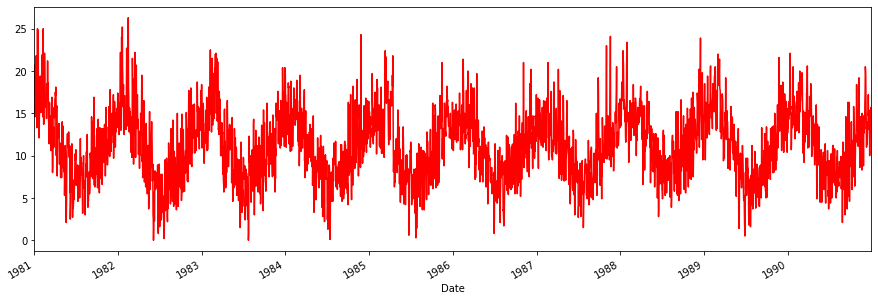

In [5]:
 df.Temp.plot(figsize=(15,5), color="r")

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [7]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [8]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [20]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [21]:
config = set_config({
    "input_size" : train_set.n_feature,
    "seq_len" : train_set.n_seq,
    "output_size" : 1, 
    "hidden_size" : 64, 
    "num_layers"  : 3,
    "dropout"     : 0
})

# Training Preparation -> MCOC

In [22]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

# Training

In [23]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 130.4567 | Test_cost  = 120.2819 | 




Epoch     2
Train_cost  = 99.9902 | Test_cost  = 88.3715 | 




Epoch     3
Train_cost  = 73.8044 | Test_cost  = 69.3816 | 




Epoch     4
Train_cost  = 59.3951 | Test_cost  = 58.5929 | 




Epoch     5
Train_cost  = 50.5918 | Test_cost  = 50.9089 | 




Epoch     6
Train_cost  = 43.9974 | Test_cost  = 44.7311 | 




Epoch     7
Train_cost  = 38.6514 | Test_cost  = 39.6224 | 




Epoch     8
Train_cost  = 34.2473 | Test_cost  = 35.3717 | 




Epoch     9
Train_cost  = 30.6139 | Test_cost  = 31.8415 | 




Epoch    10
Train_cost  = 27.6311 | Test_cost  = 28.9249 | 




Epoch    11
Train_cost  = 25.2003 | Test_cost  = 26.5297 | 




Epoch    12
Train_cost  = 23.2347 | Test_cost  = 24.5746 | 




Epoch    13
Train_cost  = 21.6581 | Test_cost  = 22.9883 | 




Epoch    14
Train_cost  = 20.4040 | Test_cost  = 21.7090 | 




Epoch    15
Train_cost  = 19.4150 | Test_cost  = 20.6832 | 




Epoch    16
Train_cost  = 18.6421 | Test_cost  = 19.8656 | 




Epoch    17
Train_cost  = 18.0435 | Test_cost  = 19.2175 | 




Epoch    18
Train_cost  = 17.5844 | Test_cost  = 18.7064 | 




Epoch    19
Train_cost  = 17.2354 | Test_cost  = 18.3051 | 




Epoch    20
Train_cost  = 16.9727 | Test_cost  = 17.9912 | 


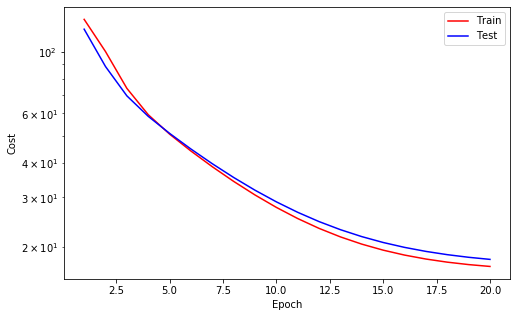



Epoch    21
Train_cost  = 16.7766 | Test_cost  = 17.7465 | 




Epoch    22
Train_cost  = 16.6315 | Test_cost  = 17.5560 | 




Epoch    23
Train_cost  = 16.5249 | Test_cost  = 17.4080 | 




Epoch    24
Train_cost  = 16.4470 | Test_cost  = 17.2928 | 




Epoch    25
Train_cost  = 16.3903 | Test_cost  = 17.2033 | 




Epoch    26
Train_cost  = 16.3492 | Test_cost  = 17.1335 | 




Epoch    27
Train_cost  = 16.3192 | Test_cost  = 17.0789 | 




Epoch    28
Train_cost  = 16.2972 | Test_cost  = 17.0361 | 




Epoch    29
Train_cost  = 16.2808 | Test_cost  = 17.0024 | 




Epoch    30
Train_cost  = 16.2684 | Test_cost  = 16.9757 | 




Epoch    31
Train_cost  = 16.2588 | Test_cost  = 16.9545 | 




Epoch    32
Train_cost  = 16.2512 | Test_cost  = 16.9376 | 




Epoch    33
Train_cost  = 16.2448 | Test_cost  = 16.9240 | 




Epoch    34
Train_cost  = 16.2393 | Test_cost  = 16.9130 | 




Epoch    35
Train_cost  = 16.2344 | Test_cost  = 16.9040 | 




Epoch    36
Train_cost  = 16.2300 | Test_cost  = 16.8967 | 




Epoch    37
Train_cost  = 16.2258 | Test_cost  = 16.8905 | 




Epoch    38
Train_cost  = 16.2217 | Test_cost  = 16.8853 | 




Epoch    39
Train_cost  = 16.2178 | Test_cost  = 16.8808 | 




Epoch    40
Train_cost  = 16.2140 | Test_cost  = 16.8769 | 


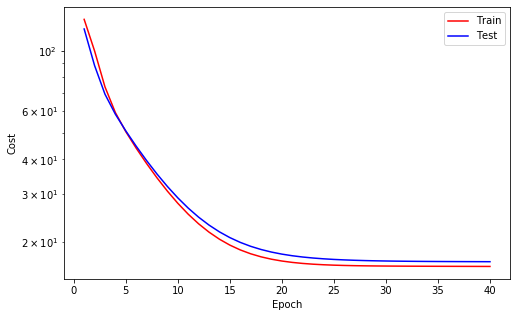



Epoch    41
Train_cost  = 16.2101 | Test_cost  = 16.8734 | 




Epoch    42
Train_cost  = 16.2062 | Test_cost  = 16.8703 | 




Epoch    43
Train_cost  = 16.2023 | Test_cost  = 16.8673 | 




Epoch    44
Train_cost  = 16.1984 | Test_cost  = 16.8646 | 




Epoch    45
Train_cost  = 16.1944 | Test_cost  = 16.8620 | 




Epoch    46
Train_cost  = 16.1903 | Test_cost  = 16.8595 | 




Epoch    47
Train_cost  = 16.1861 | Test_cost  = 16.8570 | 




Epoch    48
Train_cost  = 16.1818 | Test_cost  = 16.8546 | 




Epoch    49
Train_cost  = 16.1774 | Test_cost  = 16.8522 | 




Epoch    50
Train_cost  = 16.1728 | Test_cost  = 16.8499 | 




Epoch    51
Train_cost  = 16.1682 | Test_cost  = 16.8475 | 




Epoch    52
Train_cost  = 16.1633 | Test_cost  = 16.8451 | 




Epoch    53
Train_cost  = 16.1583 | Test_cost  = 16.8427 | 




Epoch    54
Train_cost  = 16.1530 | Test_cost  = 16.8402 | 




Epoch    55
Train_cost  = 16.1475 | Test_cost  = 16.8376 | 




Epoch    56
Train_cost  = 16.1416 | Test_cost  = 16.8350 | 




Epoch    57
Train_cost  = 16.1354 | Test_cost  = 16.8322 | 




Epoch    58
Train_cost  = 16.1286 | Test_cost  = 16.8293 | 




Epoch    59
Train_cost  = 16.1212 | Test_cost  = 16.8261 | 




Epoch    60
Train_cost  = 16.1130 | Test_cost  = 16.8226 | 


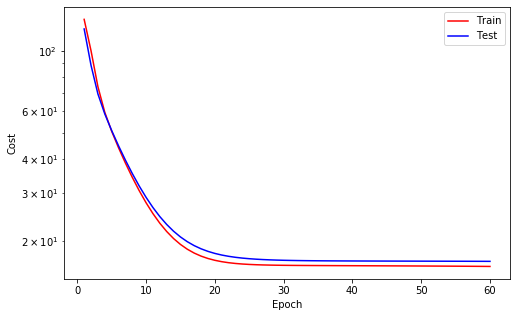



Epoch    61
Train_cost  = 16.1037 | Test_cost  = 16.8186 | 




Epoch    62
Train_cost  = 16.0927 | Test_cost  = 16.8135 | 




Epoch    63
Train_cost  = 16.0790 | Test_cost  = 16.8067 | 




Epoch    64
Train_cost  = 16.0608 | Test_cost  = 16.7962 | 




Epoch    65
Train_cost  = 16.0336 | Test_cost  = 16.7759 | 




Epoch    66
Train_cost  = 15.9834 | Test_cost  = 16.7175 | 




Epoch    67
Train_cost  = 15.8414 | Test_cost  = 16.4141 | 




Epoch    68
Train_cost  = 14.9718 | Test_cost  = 15.1274 | 




Epoch    69
Train_cost  = 13.7176 | Test_cost  = 14.1682 | 




Epoch    70
Train_cost  = 12.8124 | Test_cost  = 12.8342 | 




Epoch    71
Train_cost  = 11.8779 | Test_cost  = 11.9580 | 




Epoch    72
Train_cost  = 11.1551 | Test_cost  = 11.1934 | 




Epoch    73
Train_cost  = 10.5993 | Test_cost  = 10.4282 | 




Epoch    74
Train_cost  = 10.0422 | Test_cost  = 9.8175 | 




Epoch    75
Train_cost  = 9.6038 | Test_cost  = 9.3105 | 




Epoch    76
Train_cost  = 9.2463 | Test_cost  = 8.8554 | 




Epoch    77
Train_cost  = 8.9263 | Test_cost  = 8.4803 | 




Epoch    78
Train_cost  = 8.6476 | Test_cost  = 8.1708 | 




Epoch    79
Train_cost  = 8.4088 | Test_cost  = 7.9068 | 




Epoch    80
Train_cost  = 8.2015 | Test_cost  = 7.6766 | 


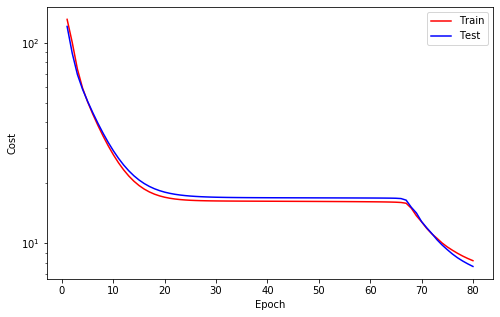



Epoch    81
Train_cost  = 8.0209 | Test_cost  = 7.4744 | 




Epoch    82
Train_cost  = 7.8641 | Test_cost  = 7.2962 | 




Epoch    83
Train_cost  = 7.7271 | Test_cost  = 7.1392 | 




Epoch    84
Train_cost  = 7.6066 | Test_cost  = 7.0002 | 




Epoch    85
Train_cost  = 7.4997 | Test_cost  = 6.8761 | 




Epoch    86
Train_cost  = 7.4042 | Test_cost  = 6.7654 | 




Epoch    87
Train_cost  = 7.3189 | Test_cost  = 6.6661 | 




Epoch    88
Train_cost  = 7.2426 | Test_cost  = 6.5767 | 




Epoch    89
Train_cost  = 7.1740 | Test_cost  = 6.4955 | 




Epoch    90
Train_cost  = 7.1121 | Test_cost  = 6.4212 | 




Epoch    91
Train_cost  = 7.0559 | Test_cost  = 6.3528 | 




Epoch    92
Train_cost  = 7.0045 | Test_cost  = 6.2894 | 




Epoch    93
Train_cost  = 6.9572 | Test_cost  = 6.2305 | 




Epoch    94
Train_cost  = 6.9135 | Test_cost  = 6.1754 | 




Epoch    95
Train_cost  = 6.8730 | Test_cost  = 6.1239 | 




Epoch    96
Train_cost  = 6.8354 | Test_cost  = 6.0758 | 




Epoch    97
Train_cost  = 6.8004 | Test_cost  = 6.0307 | 




Epoch    98
Train_cost  = 6.7678 | Test_cost  = 5.9884 | 




Epoch    99
Train_cost  = 6.7375 | Test_cost  = 5.9486 | 




Epoch   100
Train_cost  = 6.7090 | Test_cost  = 5.9110 | 


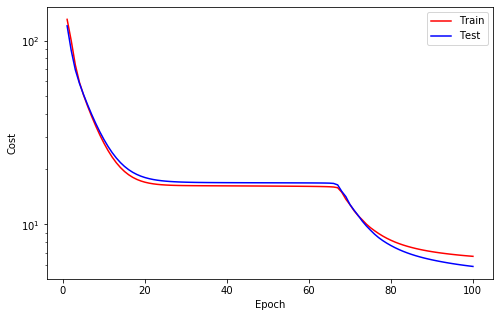



Epoch   101
Train_cost  = 6.6822 | Test_cost  = 5.8754 | 




Epoch   102
Train_cost  = 6.6568 | Test_cost  = 5.8417 | 




Epoch   103
Train_cost  = 6.6324 | Test_cost  = 5.8096 | 




Epoch   104
Train_cost  = 6.6089 | Test_cost  = 5.7790 | 




Epoch   105
Train_cost  = 6.5862 | Test_cost  = 5.7498 | 




Epoch   106
Train_cost  = 6.5644 | Test_cost  = 5.7219 | 




Epoch   107
Train_cost  = 6.5435 | Test_cost  = 5.6953 | 




Epoch   108
Train_cost  = 6.5238 | Test_cost  = 5.6697 | 




Epoch   109
Train_cost  = 6.5053 | Test_cost  = 5.6452 | 




Epoch   110
Train_cost  = 6.4880 | Test_cost  = 5.6216 | 




Epoch   111
Train_cost  = 6.4715 | Test_cost  = 5.5991 | 




Epoch   112
Train_cost  = 6.4559 | Test_cost  = 5.5774 | 




Epoch   113
Train_cost  = 6.4410 | Test_cost  = 5.5566 | 




Epoch   114
Train_cost  = 6.4267 | Test_cost  = 5.5366 | 




Epoch   115
Train_cost  = 6.4130 | Test_cost  = 5.5175 | 




Epoch   116
Train_cost  = 6.3998 | Test_cost  = 5.4993 | 




Epoch   117
Train_cost  = 6.3872 | Test_cost  = 5.4819 | 




Epoch   118
Train_cost  = 6.3751 | Test_cost  = 5.4653 | 




Epoch   119
Train_cost  = 6.3635 | Test_cost  = 5.4494 | 




Epoch   120
Train_cost  = 6.3525 | Test_cost  = 5.4343 | 


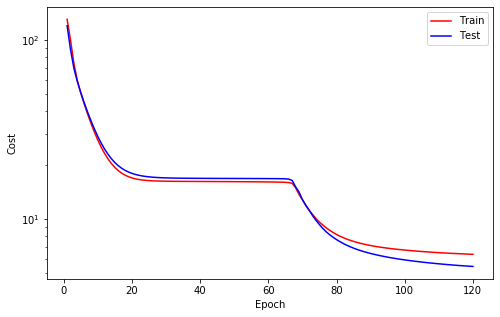



Epoch   121
Train_cost  = 6.3419 | Test_cost  = 5.4199 | 




Epoch   122
Train_cost  = 6.3317 | Test_cost  = 5.4060 | 




Epoch   123
Train_cost  = 6.3220 | Test_cost  = 5.3928 | 




Epoch   124
Train_cost  = 6.3127 | Test_cost  = 5.3802 | 




Epoch   125
Train_cost  = 6.3038 | Test_cost  = 5.3680 | 




Epoch   126
Train_cost  = 6.2952 | Test_cost  = 5.3564 | 




Epoch   127
Train_cost  = 6.2869 | Test_cost  = 5.3452 | 




Epoch   128
Train_cost  = 6.2789 | Test_cost  = 5.3344 | 




Epoch   129
Train_cost  = 6.2712 | Test_cost  = 5.3241 | 




Epoch   130
Train_cost  = 6.2638 | Test_cost  = 5.3141 | 




Epoch   131
Train_cost  = 6.2566 | Test_cost  = 5.3045 | 




Epoch   132
Train_cost  = 6.2496 | Test_cost  = 5.2953 | 




Epoch   133
Train_cost  = 6.2429 | Test_cost  = 5.2863 | 




Epoch   134
Train_cost  = 6.2363 | Test_cost  = 5.2777 | 




Epoch   135
Train_cost  = 6.2300 | Test_cost  = 5.2693 | 




Epoch   136
Train_cost  = 6.2238 | Test_cost  = 5.2611 | 




Epoch   137
Train_cost  = 6.2178 | Test_cost  = 5.2531 | 




Epoch   138
Train_cost  = 6.2119 | Test_cost  = 5.2452 | 




Epoch   139
Train_cost  = 6.2060 | Test_cost  = 5.2374 | 




Epoch   140
Train_cost  = 6.2001 | Test_cost  = 5.2297 | 


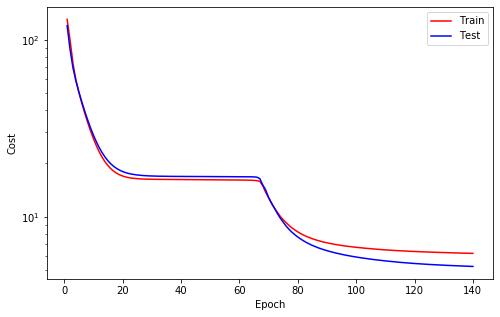



Epoch   141
Train_cost  = 6.1941 | Test_cost  = 5.2221 | 




Epoch   142
Train_cost  = 6.1878 | Test_cost  = 5.2147 | 




Epoch   143
Train_cost  = 6.1814 | Test_cost  = 5.2076 | 




Epoch   144
Train_cost  = 6.1749 | Test_cost  = 5.2008 | 




Epoch   145
Train_cost  = 6.1684 | Test_cost  = 5.1944 | 




Epoch   146
Train_cost  = 6.1620 | Test_cost  = 5.1883 | 




Epoch   147
Train_cost  = 6.1556 | Test_cost  = 5.1824 | 




Epoch   148
Train_cost  = 6.1495 | Test_cost  = 5.1769 | 




Epoch   149
Train_cost  = 6.1435 | Test_cost  = 5.1715 | 




Epoch   150
Train_cost  = 6.1377 | Test_cost  = 5.1664 | 




Epoch   151
Train_cost  = 6.1320 | Test_cost  = 5.1615 | 




Epoch   152
Train_cost  = 6.1265 | Test_cost  = 5.1567 | 




Epoch   153
Train_cost  = 6.1211 | Test_cost  = 5.1522 | 




Epoch   154
Train_cost  = 6.1158 | Test_cost  = 5.1478 | 




Epoch   155
Train_cost  = 6.1106 | Test_cost  = 5.1437 | 




Epoch   156
Train_cost  = 6.1054 | Test_cost  = 5.1397 | 




Epoch   157
Train_cost  = 6.1002 | Test_cost  = 5.1359 | 




Epoch   158
Train_cost  = 6.0951 | Test_cost  = 5.1323 | 




Epoch   159
Train_cost  = 6.0900 | Test_cost  = 5.1289 | 




Epoch   160
Train_cost  = 6.0849 | Test_cost  = 5.1257 | 


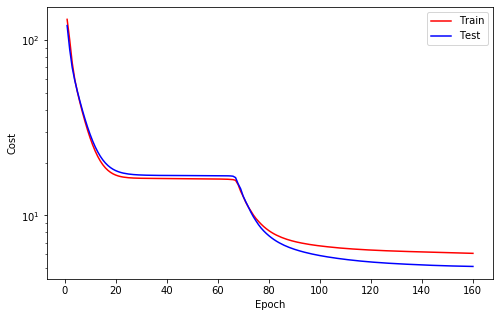



Epoch   161
Train_cost  = 6.0799 | Test_cost  = 5.1226 | 




Epoch   162
Train_cost  = 6.0749 | Test_cost  = 5.1198 | 




Epoch   163
Train_cost  = 6.0699 | Test_cost  = 5.1172 | 




Epoch   164
Train_cost  = 6.0650 | Test_cost  = 5.1148 | 




Epoch   165
Train_cost  = 6.0601 | Test_cost  = 5.1126 | 




Epoch   166
Train_cost  = 6.0553 | Test_cost  = 5.1106 | 




Epoch   167
Train_cost  = 6.0505 | Test_cost  = 5.1087 | 




Epoch   168
Train_cost  = 6.0458 | Test_cost  = 5.1071 | 




Epoch   169
Train_cost  = 6.0411 | Test_cost  = 5.1056 | 




Epoch   170
Train_cost  = 6.0364 | Test_cost  = 5.1043 | 




Epoch   171
Train_cost  = 6.0317 | Test_cost  = 5.1031 | 




Epoch   172
Train_cost  = 6.0271 | Test_cost  = 5.1021 | 




Epoch   173
Train_cost  = 6.0224 | Test_cost  = 5.1012 | 




Epoch   174
Train_cost  = 6.0178 | Test_cost  = 5.1005 | 




Epoch   175
Train_cost  = 6.0132 | Test_cost  = 5.0999 | 




Epoch   176
Train_cost  = 6.0085 | Test_cost  = 5.0994 | 




Epoch   177
Train_cost  = 6.0038 | Test_cost  = 5.0991 | 




Epoch   178
Train_cost  = 5.9991 | Test_cost  = 5.0989 | 




Epoch   179
Train_cost  = 5.9943 | Test_cost  = 5.0989 | 




Epoch   180
Train_cost  = 5.9895 | Test_cost  = 5.0990 | 


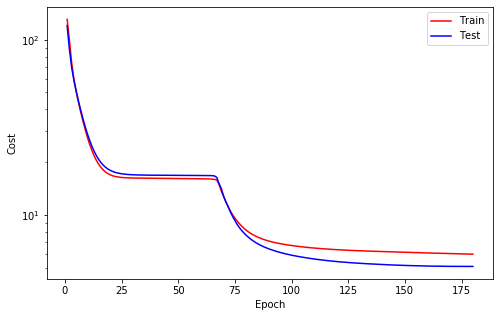

==> EarlyStop patience =  1 | Best test_cost: 5.0989




Epoch   181
Train_cost  = 5.9847 | Test_cost  = 5.0992 | 
==> EarlyStop patience =  2 | Best test_cost: 5.0989




Epoch   182
Train_cost  = 5.9798 | Test_cost  = 5.0995 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0989




Epoch   183
Train_cost  = 5.9749 | Test_cost  = 5.0999 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0989




Epoch   184
Train_cost  = 5.9700 | Test_cost  = 5.1005 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0989
==> Execute Early Stopping at epoch: 184 | Best test_cost: 5.0989
==> Best model is saved at model/gru


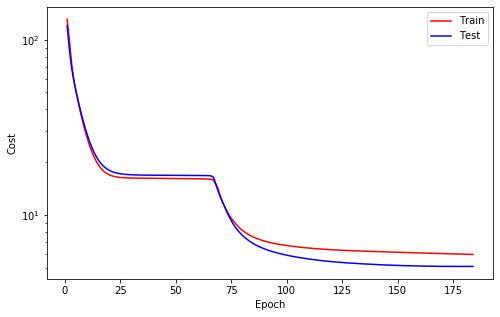

In [24]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [25]:
from luwiji.rnn import illustration

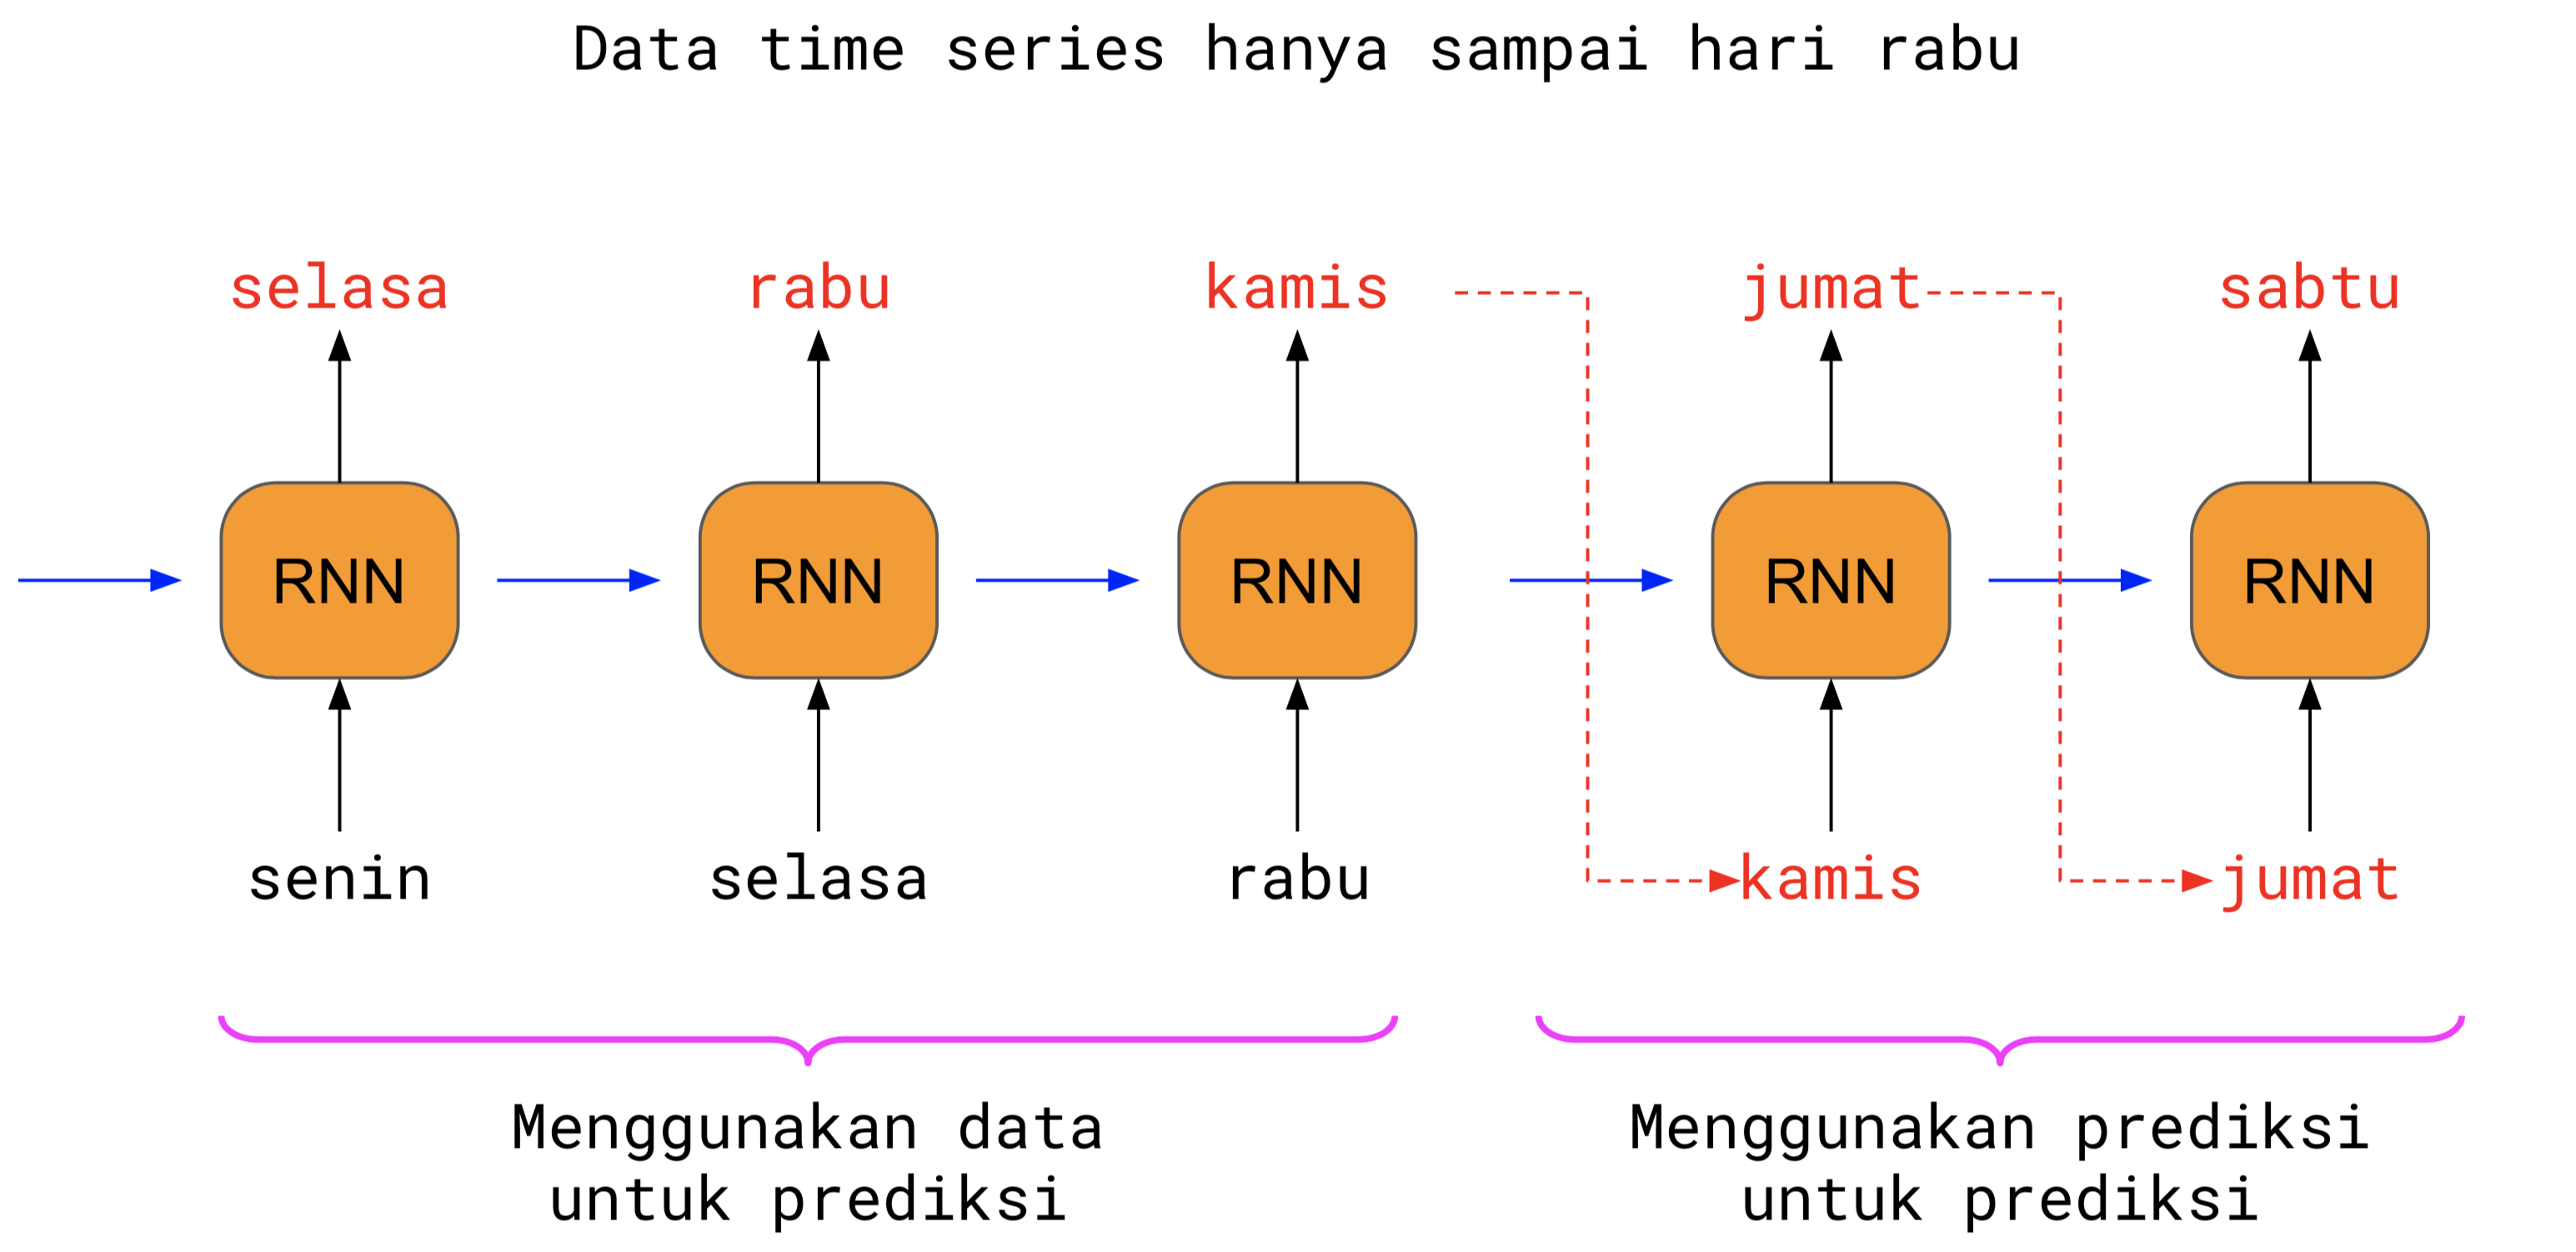

In [26]:
illustration.forecast

In [27]:
from utils import data4pred, pred4pred

In [28]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

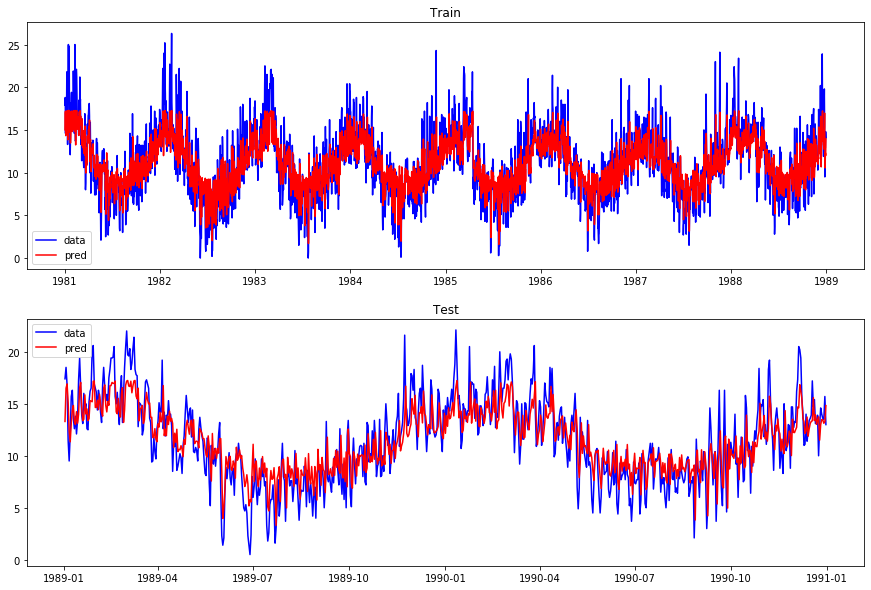

In [29]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

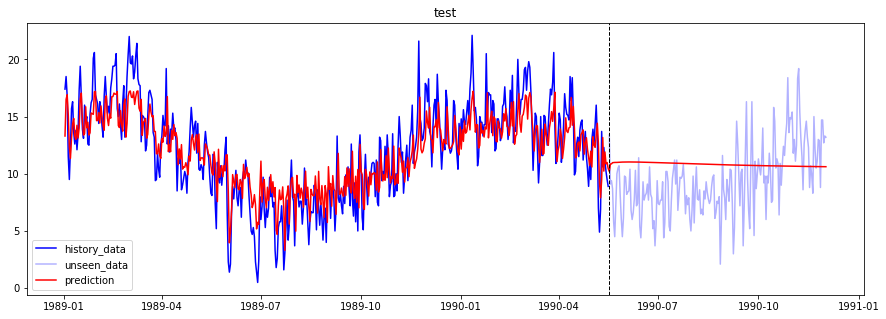

In [30]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")